In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [4]:
df = pd.read_csv('kaupskra.csv', usecols=('faerslunumer', 'postnr', 'sveitarfelag', 'utgdag', 'kaupverd', 'fasteignamat', 'byggar', 'einflm', 'lod_flm', 'tegund', 'fullbuid', 'onothaefur_samningur')) 
df = df[df["onothaefur_samningur"] == 0]
df = df[df["tegund"].isin(['Serbyli', 'Fjolbyli', 'Atvinnuhusnaedi'])]
df = df[df["sveitarfelag"].isin(['Kópavogsbær', 'Hafnarfjarðarkaupstaður', 'Reykjavíkurborg', 'Mosfellsbær', 'Garðabær', 'Seltjarnarnesbær', 'Kjósarhreppur'])]
df.head()

,faerslunumer,postnr,sveitarfelag,utgdag,kaupverd,fasteignamat,byggar,einflm,lod_flm,tegund,fullbuid,onothaefur_samningur
0,569113,200.0,Kópavogsbær,7/30/2012 0:00,87000,70850,1985,780.4,1105.0,Atvinnuhusnaedi,1,0
1,558760,220.0,Hafnarfjarðarkaupstaður,2/28/2011 0:00,36000,40790,1983,400.0,3000.0,Atvinnuhusnaedi,1,0
4,628860,104.0,Reykjavíkurborg,2/20/2018 0:00,23500,13200,1962,71.4,565.0,Atvinnuhusnaedi,1,0
11,686375,105.0,Reykjavíkurborg,3/25/2022 0:00,25500,10650,1992,47.5,5702.0,Atvinnuhusnaedi,1,0
12,685833,105.0,Reykjavíkurborg,3/7/2022 0:00,68250,55700,1992,109.9,5702.0,Fjolbyli,1,0


In [5]:
df = df.drop(['onothaefur_samningur', 'faerslunumer'], axis=1)
df.dropna(inplace=True)

In [6]:
df = df[df.byggar != ' ']
df['byggar'] = df['byggar'].astype(int)

In [7]:
Q1 = df.quantile(0.10)
Q3 = df.quantile(0.90)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\halld\AppData\Local\Temp\ipykernel_16360\3233543811.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


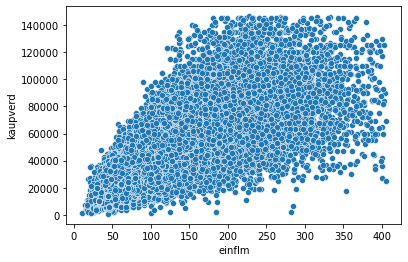

In [8]:
sns.scatterplot(x='einflm', y='kaupverd', data=df)
plt.show()

In [9]:
df['utgdag'] = df['utgdag'].str[:-4]
df['utgdag'] = pd.to_datetime(df['utgdag'])
df.sort_values('utgdag', ascending=True, inplace=True)
data = pd.get_dummies(df, columns = ['postnr', 'sveitarfelag', 'tegund'])
data.head()

,utgdag,kaupverd,fasteignamat,byggar,einflm,lod_flm,fullbuid,postnr_101.0,postnr_102.0,postnr_103.0,...,sveitarfelag_Garðabær,sveitarfelag_Hafnarfjarðarkaupstaður,sveitarfelag_Kjósarhreppur,sveitarfelag_Kópavogsbær,sveitarfelag_Mosfellsbær,sveitarfelag_Reykjavíkurborg,sveitarfelag_Seltjarnarnesbær,tegund_Atvinnuhusnaedi,tegund_Fjolbyli,tegund_Serbyli
86686,2006-03-01,11050,17330,1958,224.0,7000.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
38968,2006-03-14,24700,19820,1988,112.3,1285.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
112433,2006-03-17,65000,43800,2003,290.7,632.8,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
62152,2006-04-10,11900,12090,1972,78.1,7940.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
107788,2006-04-21,17300,15110,1993,89.0,1339.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [10]:
data['utgdag'] = data['utgdag'] + pd.offsets.MonthBegin(0)
data.head()

,utgdag,kaupverd,fasteignamat,byggar,einflm,lod_flm,fullbuid,postnr_101.0,postnr_102.0,postnr_103.0,...,sveitarfelag_Garðabær,sveitarfelag_Hafnarfjarðarkaupstaður,sveitarfelag_Kjósarhreppur,sveitarfelag_Kópavogsbær,sveitarfelag_Mosfellsbær,sveitarfelag_Reykjavíkurborg,sveitarfelag_Seltjarnarnesbær,tegund_Atvinnuhusnaedi,tegund_Fjolbyli,tegund_Serbyli
86686,2006-03-01,11050,17330,1958,224.0,7000.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
38968,2006-04-01,24700,19820,1988,112.3,1285.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
112433,2006-04-01,65000,43800,2003,290.7,632.8,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
62152,2006-05-01,11900,12090,1972,78.1,7940.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
107788,2006-05-01,17300,15110,1993,89.0,1339.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [11]:
df1 = df.copy()
df.to_csv('b4dummies.csv')
serbyli = df1[df1['tegund'] == 'Serbyli']
fjolbyli = df1[df1['tegund'] == 'Fjolbyli']

serbyli.drop('tegund', axis=1, inplace=True)
fjolbyli.drop('tegund', axis=1, inplace=True)
serbyli = pd.get_dummies(serbyli, columns = ['postnr', 'sveitarfelag'])
serbyli['utgdag'] = serbyli['utgdag'] + pd.offsets.MonthBegin(0)
fjolbyli = pd.get_dummies(fjolbyli, columns = ['postnr', 'sveitarfelag'])
fjolbyli['utgdag'] = fjolbyli['utgdag'] + pd.offsets.MonthBegin(0)

C:\Users\halld\AppData\Local\Temp\ipykernel_16360\4068797815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serbyli.drop('tegund', axis=1, inplace=True)
C:\Users\halld\AppData\Local\Temp\ipykernel_16360\4068797815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fjolbyli.drop('tegund', axis=1, inplace=True)


In [12]:
serbyli.to_csv('serbyli_CLEAN.csv')
fjolbyli.to_csv('fjolbyli_CLEAN.csv')

In [13]:
variables = pd.read_csv('merged_variables.csv')
variables['date'] = pd.to_datetime(variables['date'])
variables.head()

,Unnamed: 0,date,overdtryggt,verdtryggt,visitala_rvk_%,verdbolga_%
0,0,2006-01-01,12.5,4.15,0.5,-0.259179
1,1,2006-02-01,12.5,4.15,2.0,-0.259179
2,2,2006-03-01,12.5,4.15,1.7,1.169337
3,3,2006-04-01,12.5,4.30,1.2,1.070205
4,4,2006-05-01,13.0,4.60,-0.2,1.482423


In [14]:
merged_data = pd.merge(data, variables, left_on='utgdag', right_on='date')
merged_data.drop(['date', 'Unnamed: 0'], axis=1, inplace=True)
merged_data.head()

,utgdag,kaupverd,fasteignamat,byggar,einflm,lod_flm,fullbuid,postnr_101.0,postnr_102.0,postnr_103.0,...,sveitarfelag_Mosfellsbær,sveitarfelag_Reykjavíkurborg,sveitarfelag_Seltjarnarnesbær,tegund_Atvinnuhusnaedi,tegund_Fjolbyli,tegund_Serbyli,overdtryggt,verdtryggt,visitala_rvk_%,verdbolga_%
0,2006-03-01,11050,17330,1958,224.0,7000.0,1,0,0,0,...,0,1,0,0,0,1,12.5,4.15,1.7,1.169337
1,2006-04-01,24700,19820,1988,112.3,1285.0,1,0,0,0,...,0,1,0,0,1,0,12.5,4.30,1.2,1.070205
2,2006-04-01,65000,43800,2003,290.7,632.8,1,0,0,0,...,0,0,0,0,0,1,12.5,4.30,1.2,1.070205
3,2006-05-01,11900,12090,1972,78.1,7940.0,1,0,0,0,...,0,1,0,0,1,0,13.0,4.60,-0.2,1.482423
4,2006-05-01,17300,15110,1993,89.0,1339.0,1,0,0,0,...,0,1,0,0,1,0,13.0,4.60,-0.2,1.482423


In [15]:
X = merged_data.drop('kaupverd', axis=1)
y = data['kaupverd']
X.set_index('utgdag', inplace=True)

In [16]:
scaler = preprocessing.MinMaxScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

In [17]:
X_train = Xs[:int(Xs.shape[0]*0.8)]
X_test = Xs[int(Xs.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]

In [18]:
regr = LinearRegression()
regr.fit(X_train,y_train)
regr.score(X_train,y_train)

0.8546508536730618

In [19]:
y_hat = regr.predict(X_test)

In [20]:
len(X_train.columns)

46

In [21]:
combined = data[int(data.shape[0]*0.8):]
combined['predicted price'] = y_hat
combined.head()

C:\Users\halld\AppData\Local\Temp\ipykernel_16360\2203313243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['predicted price'] = y_hat


,utgdag,kaupverd,fasteignamat,byggar,einflm,lod_flm,fullbuid,postnr_101.0,postnr_102.0,postnr_103.0,...,sveitarfelag_Hafnarfjarðarkaupstaður,sveitarfelag_Kjósarhreppur,sveitarfelag_Kópavogsbær,sveitarfelag_Mosfellsbær,sveitarfelag_Reykjavíkurborg,sveitarfelag_Seltjarnarnesbær,tegund_Atvinnuhusnaedi,tegund_Fjolbyli,tegund_Serbyli,predicted price
140834,2020-05-01,51900,45500,2019,102.4,1464.0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,52667.920115
67494,2020-05-01,94000,91350,1974,291.8,1016.0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,100847.479885
46681,2020-05-01,41000,42250,1961,96.9,3798.0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,46234.087945
127100,2020-05-01,53000,50200,1981,140.4,1121.0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,55860.772794
156973,2020-05-01,76900,63350,2019,130.3,3188.0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,70777.201924


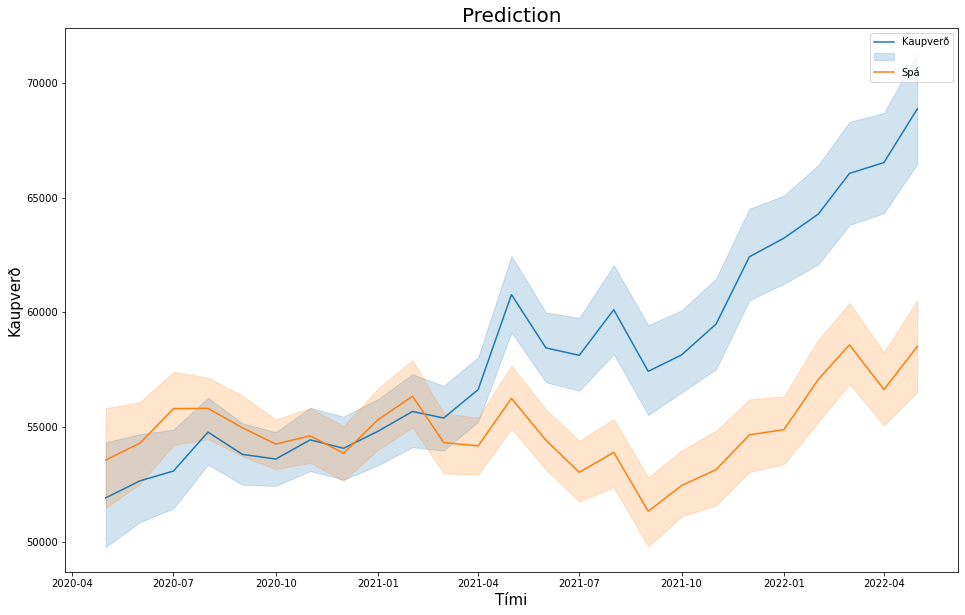

In [22]:
plt.figure(figsize=(16,10))
sns.lineplot(x='utgdag', y='kaupverd', data=combined)
sns.lineplot(x='utgdag', y='predicted price', data=combined)
plt.title('Prediction', fontsize='20')
plt.xlabel('Tími', fontsize='15')
plt.ylabel('Kaupverð', fontsize='15')
plt.legend(['Kaupverð', '', 'Spá'])


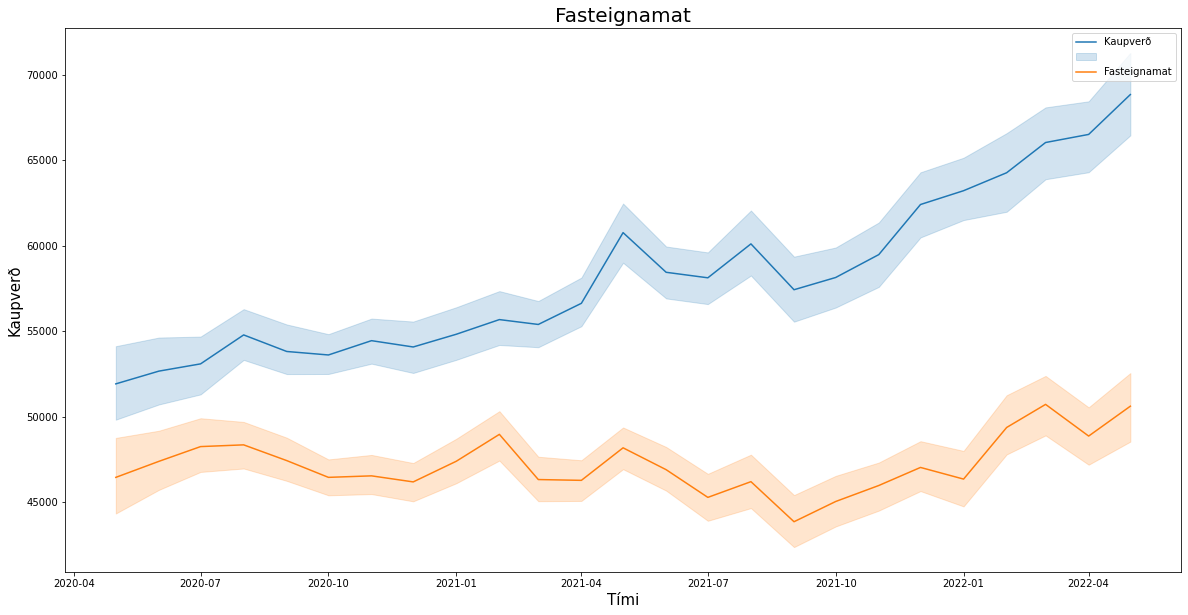

In [23]:
plt.figure(figsize=(20,10))
sns.lineplot(x='utgdag', y='kaupverd', data=combined)
sns.lineplot(x='utgdag', y='fasteignamat', data=combined)
plt.title('Fasteignamat', fontsize='20')
plt.xlabel('Tími', fontsize='15')
plt.ylabel('Kaupverð', fontsize='15')
plt.legend(['Kaupverð', '', 'Fasteignamat'])

In [24]:
importance = regr.coef_
importance = pd.DataFrame(importance).T
importance.columns = X_test.columns
importance = importance.T
importance.head()

,0
fasteignamat,1.017591e+05
byggar,1.835595e+04
einflm,2.617269e+04
lod_flm,-3.444868e+01
fullbuid,9.276846e-11


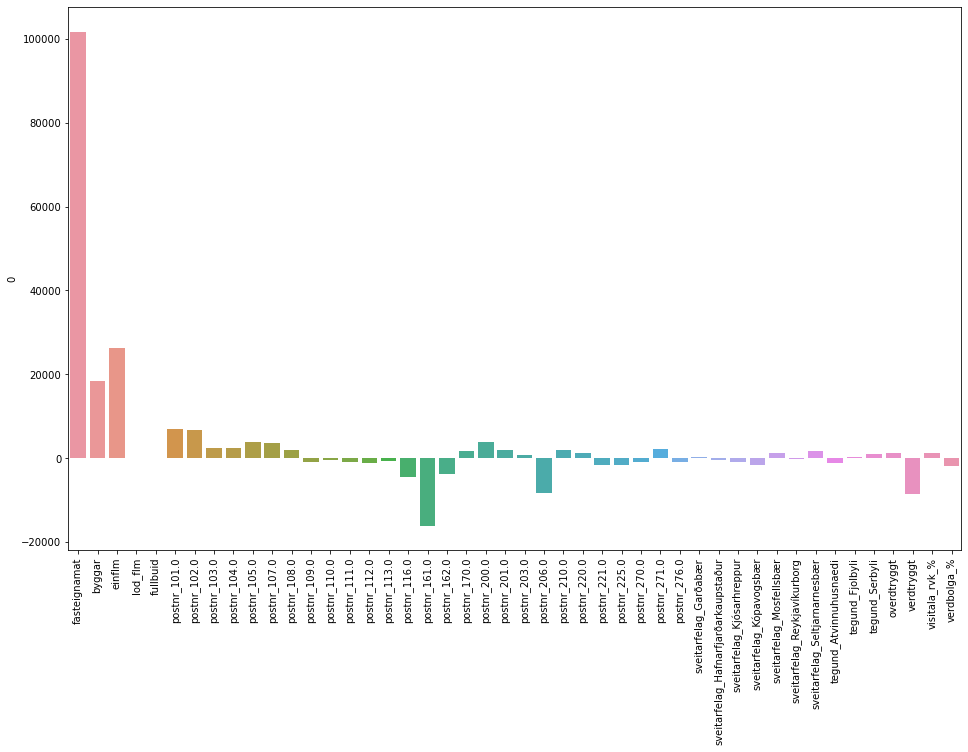

In [25]:
plt.figure(figsize=(16,10))
sns.barplot(x=importance.index, y=0, data=importance)
plt.xticks(rotation = 90)
plt.savefig('Coefficient Importance')